# Baseline Digit Recognition (PyTorch)


**WORKFLOWS**

**Load and Prepare Dataset:** 
* Import necessary libraries.
* Load the MNIST dataset using torchvision.
* Normalize and transform the dataset.
* Create data loaders for training and testing.

**Implement FFN Class:** 
* Define a class for the Feedforward Neural Network (FFN) with three dense layers.
* Implement the forward pass method.

**Define Training Loop:**
* Set up the loss function and optimizer.
* Implement the training loop.
* Include methods of regularization (e.g., dropout, weight decay).

In [484]:
from IPython.display import display, HTML
from datetime import datetime

def display_last_setup_notebook():
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    html_content = f"""
    <div style="display: flex;  border: 1px solid black; padding: 10px 10px 10px 100px; margin: 10px;">
        <h2>Last run notebook: <span style="font-size:18px">{current_time}</span></h2>
        <h2 style="margin-left: 5%; margin-top: 1.3%">Accuracy baseline: <span style="font-size:18px">95.76%</span></h2>
        <h2 style="margin-left: 5%; margin-top: 1.3%">Total number of parameters: <span style="font-size:18px">55 050</span></h2>
    </div>
    """
    display(HTML(html_content))

# Call the function to display the cell
display_last_setup_notebook()

## Load and Prepare Dataset

### Import all necessary libraries

In [163]:
import torch 
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from torch.nn.functional import relu
from torch.nn import MSELoss
import torchvision

### Loading the MNIST dataset into the working directory

In [242]:
mnist_dataset = torchvision.datasets.MNIST("../data", download=False)
data = mnist_dataset.data.numpy()
targets = mnist_dataset.targets.numpy()

data_length = len(data)
targets_length = len(targets)

print("Amount of data: %s\n\nAmount of labels: %s" % (data_length, targets_length))

Amount of data: 60000

Amount of labels: 60000


### Define custom dataset class 

In [243]:
# Custom Dataset class
class CustomMNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

### Split dataset into train and test parts

In [244]:
percent_train_data = 0.8
train_data_length = int(data_length * percent_train_data)

train_data = data[:train_data_length]
test_data = data[train_data_length:]

train_labels = targets[:train_data_length]
test_labels = targets[train_data_length:]

### Create dataloader and transform them

In [245]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = CustomMNISTDataset(train_data, train_labels, transform=transform)
test_dataset = CustomMNISTDataset(test_data, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))
print(train_batch[0].shape, train_batch[1].shape)
print(test_batch[0].shape, test_batch[1].shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])


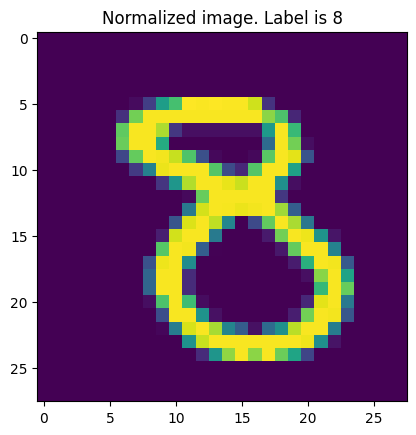

In [248]:
def show_random_image():
    random_index = random.randint(0, train_data_length)
    image, label = train_loader.dataset[random_index][0].squeeze(), train_loader.dataset[random_index][1]
    plt.title(f"Normalized image. Label is {label}")
    plt.imshow(image);

show_random_image()

## Implementation of the FFN 

### Definetion FFN class costructor 

In [254]:
class DigitRecognizer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DigitRecognizer, self).__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.activation1 = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.activation2 = nn.ReLU()
        self.output = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.input(x)
        x = self.activation1(x)
        x = self.fc(x)
        x = self.activation2(x)
        x = self.output(x)
        output = self.softmax(x)
        return output

### Implement train loop and set up the loss function and optimizer 

In [260]:
IMAGE_SHAPE = (28, 28)
INPUT_DIMENSIONS = IMAGE_SHAPE[0] * IMAGE_SHAPE[1]
HIDDEN_DIMENSIONS = 64
OUTPUT_DIMENSIONS = len(mnist_dataset.classes)
EPOCHS = 5
LEARNING_RATE = 0.001

model = DigitRecognizer(INPUT_DIMENSIONS, HIDDEN_DIMENSIONS, OUTPUT_DIMENSIONS)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

In [265]:
def train_model(model, epochs, loss_function, optimizer):
    for epoch in range(epochs):
        for images, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            output = model(images)  # Forward pass
            loss = loss_function(output, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

        print("Epoch: %d - Loss: %.4f" % (epoch + 1, loss.item()))

### Train the model and make predictions

In [266]:
train_model(model, EPOCHS, loss_function, optimizer)

Epoch: 1 - Loss: 1.5147
Epoch: 2 - Loss: 1.5663
Epoch: 3 - Loss: 1.5338
Epoch: 4 - Loss: 1.5145
Epoch: 5 - Loss: 1.4942


In [267]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, targets in test_loader:
            output = model(images)  # Forward pass
            _, predicted = torch.max(output.data, 1)  # Get the index of the max log-probability
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy

In [459]:
model_accuracy = evaluate_model(model, test_loader)

Accuracy: 95.76%


In [452]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 55050


#### A method for visually observing the abstract behavior of a model 

In [504]:
def predict_and_plot(model, image, label):
    model.eval() 
    with torch.no_grad():  
        output = model(image.unsqueeze(0)) 
        _, predicted = torch.max(output.data, 1)  

    plt.imshow(image.squeeze(), cmap='gray')
    if predicted.item() == label:
        plt.title(f"Prediction: {predicted.item()} (Correct)", color='green')
    else:
        plt.title(f"Prediction: {predicted.item()} (Incorrect)", color='red')
    plt.show()

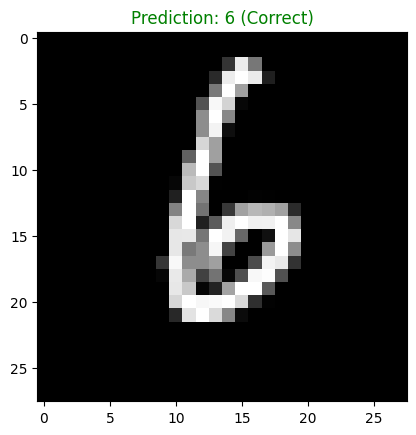

In [551]:
random_index = torch.randint(len(test_dataset), (1,)).item()
random_image, random_label = test_dataset[random_index]
predict_and_plot(model, random_image, random_label)